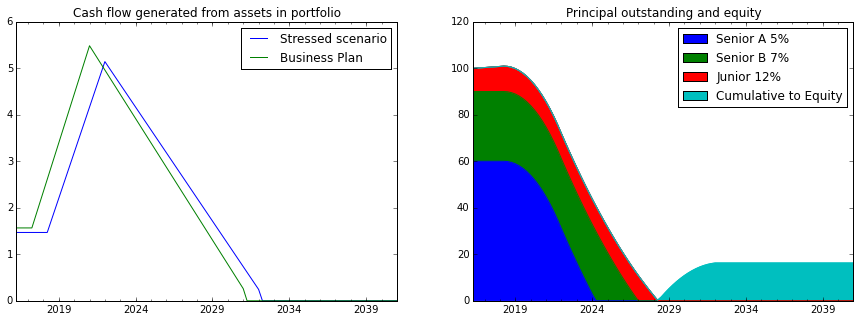

In [1]:
%matplotlib inline
import datetime
from dateutil import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *

#interest rates (divide by four as quarterly used)
int_rate=np.array([0.05,0.07,0.12])/4
#amort_rate=[0.1,0.08,0.04]
noBondClasses=3
nper=100; #number of periods

def koko(Asset_Valuation,Delay_to_Sales):
    #Inititate the capital in the three bond tranches
    bondTranches = np.array([np.zeros(nper)]*noBondClasses*4).T
      
    bondTranches[0,3]=60.0;
    bondTranches[0,7]=30;
    bondTranches[0,11]=10;
    
    def salesProfile(Delay_to_Sales,Asset_Valuation):
    # generate cash flow profile
        cashIn = np.array([np.zeros(nper)]).T
        for per in range(0,nper//20+Delay_to_Sales):
            cashIn[per]=6;
        for per in range(nper//20+Delay_to_Sales,nper//5+Delay_to_Sales):
            cashIn[per]=cashIn[per-1]+1;
        for per in range(nper//5+Delay_to_Sales,3*nper//5+Delay_to_Sales):    
            cashIn[per]=max(0,cashIn[per-1]-0.5);
        cashIn/=cashIn.sum()
        cashIn*=Asset_Valuation;
        return cashIn;
  
    
    cashOut = np.array([np.zeros(nper)]).T;
    cashIn=salesProfile(Delay_to_Sales,Asset_Valuation);
  
    
    def calcAmort(nper): 

        for per in range(1,nper):
            freeCash=cashIn[per].copy()
            
            #interest due class A
            bondTranches[per,0]=bondTranches[per-1,3]*int_rate[0];
            #interest paid class A
            bondTranches[per,1]=min(freeCash,bondTranches[per,0]);
            freeCash-=bondTranches[per,1];
            #interest capitalised in period class A
            bondTranches[per,2]=bondTranches[per,0]-bondTranches[per,1];
 
            #interest due class B
            bondTranches[per,4]=bondTranches[per-1,7]*int_rate[1];
            #interest paid class B
            bondTranches[per,5]=min(freeCash,bondTranches[per,4]);
            freeCash-=bondTranches[per,5]
            #interest capitalised in period class B
            bondTranches[per,6]=bondTranches[per,4]-bondTranches[per,5];
            
            #interest due class Jr
            bondTranches[per,8]=bondTranches[per-1,11]*int_rate[2];
            #interest paid class Jr
            bondTranches[per,9]=min(freeCash,bondTranches[per,8]);
            freeCash-=bondTranches[per,9]
            #interest capitalised in period class Jr
            bondTranches[per,10]=bondTranches[per,8]-bondTranches[per,9]
            
            #amortisation class A
            #amortDue=bondTranches[per-1,3]*amort_rate[0];
            amortDue=bondTranches[per-1,3];
            amortPaid=min(freeCash,amortDue)
            bondTranches[per,3]=bondTranches[per-1,3]-amortPaid+bondTranches[per,2]
            freeCash-=amortPaid
 
            #amortisation class B
            #amortDue=bondTranches[per-1,7]*amort_rate[1];
            amortDue=bondTranches[per-1,7];
            amortPaid=min(freeCash,amortDue)
            bondTranches[per,7]=bondTranches[per-1,7]-amortPaid+bondTranches[per,6]
            freeCash-=amortPaid
            
            #amortisation class Jr
            amortDue=bondTranches[per-1,11];
            amortPaid=min(freeCash,amortDue)
            bondTranches[per,11]=bondTranches[per-1,11]-amortPaid+bondTranches[per,10];
            freeCash-=amortPaid
            cashOut[per]=cashOut[per-1]+freeCash;
            #bondTranches[per,2]=-min(cashIn[per],bondTranches[per,0],bondTranches[0,3]*amort_rate[0]);



    calcAmort(nper);


    todays_date = datetime.datetime.now().date()
    index = pd.date_range(todays_date-datetime.timedelta(10), periods=nper, freq='Q')
    columns = ['IntDueA','IntPaidA','IntCapA', 'Senior A 5%','IntDueB','IntPaidB','IntCapB', 'Senior B 7%','IntDueJr','IntPaidJr','IntCapJr', 'Junior 12%']
    df = pd.DataFrame( bondTranches, index=index, columns=columns)
    df['Cumulative to Equity']=cashOut
    
    businessPlan=salesProfile(0,175);
    cashFlows = pd.DataFrame( cashIn, index=index, columns=['Stressed scenario']);
    cashFlows['Business Plan']=businessPlan;

    fig, axs = plt.subplots(1,2)


    df.loc[:,['Senior A 5%','Senior B 7%','Junior 12%','Cumulative to Equity']].plot(kind='area',stacked=True,ax=axs[1], figsize=(15, 5),title="Principal outstanding and equity")
   
   
    cashFlows.plot(ax=axs[0],title="Cash flow generated from assets in portfolio");


  
interact(koko,Asset_Valuation=(150,200,5),Delay_to_Sales=(-4,12,2));